In [1]:
! pip install findspark 

In [2]:
import findspark
findspark.init()

from pyspark import SparkContext, SparkConf

conf = SparkConf().setMaster("local").setAppName("PangRank")
sc = SparkContext(conf = conf)

In [9]:
from operator import add, sub
from pyspark.sql import Row

def get_edges(edge):
    source, dest, weight = list(map(int, edge.split('\t')))
    return Row(source=source, dest=dest, weight=weight)

def get_vertexes(edges):
    return edges.flatMap(lambda edge: (edge.source, edge.dest)).distinct()

def norm_L1(ranks):
    return ranks.map(lambda pair: pair[1]).reduce(add)
    
def normalize_weights(entry):
    source, (edges, sum_weights) = entry
    for edge in edges:
        yield Row(source=edge.source, dest=edge.dest, weight=edge.weight / sum_weights)

def markov_transform(entry):
    source, (edges, rank) = entry
    for edge in edges:
        yield (edge.dest, rank * edge.weight)

def compute_page_rank(input_file_name, c = 0.85, iterations = 50):
    # Read edges
    lines = sc.textFile(input_file_name)
    edges = lines.map(get_edges)

    # Re-weight edges
    edges_by_source = edges.groupBy(lambda row: row.source)
    sum_weights = edges_by_source.map(lambda x: (x[0], sum(row.weight for row in x[1])))
    edges = edges_by_source.join(sum_weights).flatMap(normalize_weights)

    # Prepare suitable data
    vertexes = get_vertexes(edges)
    vertex_count = edges.count()
    edges = edges.groupBy(lambda row: row.source)
    #print(list(map(lambda x: (x[0], list(x[1])), edges.collect())))
    #print(vertexes.collect())
    
    # Poor man's PageRank
    prev_ranks = vertexes.map(lambda vert: (vert, 1.0))
    prev_norm = norm_L1(prev_ranks)
    errors = []
    for i in range(iterations):
        partial_ranks = edges.join(prev_ranks).flatMap(markov_transform)
        partial_ranks = partial_ranks.union(vertexes.map(lambda vert: (vert, 0)))
        ranks = partial_ranks.reduceByKey(add)
        ranks = ranks.mapValues(lambda rank: c * rank)
        norm = norm_L1(ranks)
        gamma = prev_norm - norm
        ranks = ranks.map(lambda x: (x[0], x[1] + gamma / float(vertex_count)))

        error = norm_L1(ranks.union(prev_ranks).reduceByKey(sub)) / vertex_count
        errors.append(error)
        
        prev_ranks = ranks
        prev_norm = norm
    
    # Sort vertexes by rank
    prev_ranks = prev_ranks.collect()
    prev_ranks.sort(key=lambda x: x[1])
    
    return (prev_ranks, errors)

In [10]:
import numpy as np
from matplotlib import pyplot as plt

iterations = 10
ranks, errors = compute_page_rank("graph1.tsv", c=0.85, iterations = iterations)

print(ranks[-10:])

[(501, 7.293911930259997), (70768, 7.465437571149475), (786, 8.371060323578256), (17234, 8.407059877056062), (807, 9.751131497572906), (558, 12.263502567511129), (142, 12.291738751738961), (79269, 13.504146465285066), (641, 13.676167342335226), (10976, 26.79581787410098)]


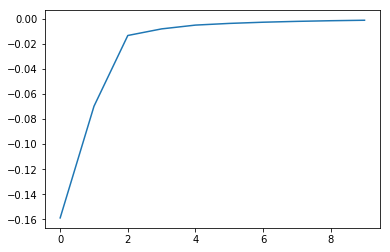

In [11]:
plt.plot(range(iterations), errors)
plt.show()

In [12]:
def save_page_ranks(ranks, output_file_name):
    with open(output_file_name, "w+") as f:
        for rank in ranks:
            f.write("%s\t%s\n" % rank)

save_page_ranks(ranks, "results.tsv")